In [1]:
import sys

sys.path.insert(0, sys.path[0] + "/src")

import json
import os
import pickle
import shutil

from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw

from config import *
from background_factory import BackgroundFactory


<h3><center>Utility functions


In [2]:
def getInitialScansPath(test_set=False):
    return Path(IMAGES_PATH, TEST if test_set else DATA, INPUT)


def getUnlabeledCardsPath(test_set=False):
    return Path(IMAGES_PATH, TEST if test_set else DATA, OUTPUT)


def getLabeledCardsPath(test_set=False):
    return Path(IMAGES_PATH, TEST if test_set else DATA, LABELED)


def getAnnotationsPath(test_set=False):
    return Path(IMAGES_PATH, TEST if test_set else DATA, ANNOTATIONS)


def getContoursPath(test_set=False):
    return Path(IMAGES_PATH, TEST if test_set else DATA, CONTOURS)


def getClassMapping(test_set=False):
    path = Path(IMAGES_PATH, CLASS_MAPPING)
    if not path.is_file():
        return None
    return json.loads(path.read_text())


def setClassMapping(dictionary, test_set=False):
    path = Path(IMAGES_PATH, CLASS_MAPPING)
    json_object = json.dumps(dictionary, indent=4)
    with path.open(mode="w") as f:
        f.write(json_object)


def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv2.resize(image, dim, interpolation=inter)


def get_font_size(text, height):
    for font_scale in range(50, 1, -1):
        text_size = cv2.getTextSize(
            text,
            fontFace=cv2.FONT_HERSHEY_DUPLEX,
            fontScale=font_scale,
            thickness=font_scale // 2,
        )
        new_size = text_size[0][1]
        if new_size < height:
            return font_scale, text_size[0]


def displayOpencvImage(image, name, width=600):
    resize_image = ResizeWithAspectRatio(image, width)
    cv2.imshow(name, resize_image)
    cv2.waitKey()
    cv2.destroyAllWindows()


<center> <h3> Downloading background images </h3> </center>


In [3]:
if not Path(IMAGES, BACKGROUNDS, BACKGROUNDS_PKL).exists():
    !mkdir -p $IMAGES$BACKGROUNDS
    !wget -O $IMAGES$BACKGROUNDS/backgrounds.tar.gz https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
    !tar -xvf $IMAGES$BACKGROUNDS/backgrounds.tar.gz -C $IMAGES$BACKGROUNDS
    !mv $IMAGES$BACKGROUNDS$DTD$IMAGES $IMAGES$BACKGROUNDS
    !rm -r $IMAGES$BACKGROUNDS$DTD
    !rm $IMAGES$BACKGROUNDS/backgrounds.tar.gz


--2022-01-03 17:05:48--  https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 625239812 (596M) [application/x-gzip]
Saving to: ‘images/backgrounds//backgrounds.tar.gz’

images/backgrounds/ 100%[===================>] 596.27M  51.5MB/s    in 12s     

2022-01-03 17:06:02 (48.3 MB/s) - ‘images/backgrounds//backgrounds.tar.gz’ saved [625239812/625239812]

dtd/
dtd/labels/
dtd/labels/test2.txt
dtd/labels/train2.txt
dtd/labels/test7.txt
dtd/labels/train3.txt
dtd/labels/train8.txt
dtd/labels/val3.txt
dtd/labels/val8.txt
dtd/labels/train10.txt
dtd/labels/train6.txt
dtd/labels/val2.txt
dtd/labels/test1.txt
dtd/labels/val5.txt
dtd/labels/test10.txt
dtd/labels/train1.txt
dtd/labels/val4.txt
dtd/labels/labels_joint_anno.txt
dtd/labels/test3.txt
dtd/labels/train9.txt
dtd/labels

<center> <h3> Process background images and pickle them </h3> </center>


In [4]:
DTD_DIR = IMAGES + BACKGROUNDS + IMAGES

bg_imgs = []
for subdir in os.listdir(DTD_DIR):
    for image in os.listdir(DTD_DIR + subdir):
        if not image.endswith(".jpg"):
            continue

        bg_imgs.append(DTD_DIR + subdir + "/" + image)

print("Number of background images:", len(bg_imgs))
pickle.dump(bg_imgs, open(IMAGES + BACKGROUNDS + BACKGROUNDS_PKL, "wb"))
print("Background images saved in", IMAGES + BACKGROUNDS + BACKGROUNDS_PKL)


Number of background images: 5640
Background images saved in images/backgrounds/backgrounds.pkl


<h3><center>Create data folder structure </center></h3>

Scans of the cards should be put into input folder of either test or data (test if for testing purposes so you presumably want to put it in data collection)


In [5]:
sets = [DATA, TEST]
dirs = [ANNOTATIONS, INPUT, LABELED, OUTPUT, CONTOURS]

for item_set in sets:
    for item_dir in dirs:
        Path(ROOT_PATH, IMAGES, SCANS, item_set, item_dir).mkdir(
            parents=True, exist_ok=True
        )


<h3><center>Extracting cards from a scan


In [6]:
test_set = True
scans_path = getInitialScansPath(test_set)
scans_out_path = getUnlabeledCardsPath(test_set)
contours_path = getContoursPath(test_set)

# Detection area threshold (compared to largest detected area)
# Used to remove dust/dirt picked by scanner and detected by opencv findContours method
AREA_THERSHOLD = 0.1
nROI = 0

for e, filepath in enumerate(scans_path.iterdir()):
    image = cv2.imread(str(filepath))
    overlay = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2BGRA)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    canny = cv2.Canny(blurred, 120, 255, 1)
    kernel = np.ones((5, 5), np.uint8)
    dilate = cv2.dilate(canny, kernel, iterations=1)

    # Find contours
    contours = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]

    # Removing unwanted contours below given threshold
    # bounding_box is a Straight Bounding Rectangle (not rotated)
    bounds = [
        {
            "bounding_box": cv2.boundingRect(cnt),
            "contour": cnt,
            "area": cv2.contourArea(cnt),
        }
        for cnt in contours
    ]
    maxROI = max(bounds, key=lambda x: x["area"])
    area_thereshold = AREA_THERSHOLD * maxROI["area"]
    bounds = [_bounds for _bounds in bounds if _bounds["area"] > area_thereshold]

    # Set font size
    overlay_h, overlay_w = overlay.shape[:2]
    rect_width = int(overlay_w * 0.05)
    font_scale, (font_width, font_height) = get_font_size(str(e), rect_width)

    # Iterate thorugh contours and filter for ROI
    for _bounds in bounds:
        rect = cv2.minAreaRect(_bounds["contour"])
        box = np.int0(cv2.boxPoints(rect))

        W = rect[1][0]
        H = rect[1][1]

        x1 = np.min(box[:, 0])
        x2 = np.max(box[:, 0])
        y1 = np.min(box[:, 1])
        y2 = np.max(box[:, 1])

        x, y, w, h = _bounds["bounding_box"]

        center = (x + w // 2, y + h // 2)

        rect_x, rect_y = (
            center[0] - int((font_width / 2) * 1.2),
            center[1] - int((font_height / 2) * 1.2),
        )
        cv2.rectangle(
            overlay,
            (rect_x, rect_y),
            (rect_x + int(font_width * 1.2), rect_y + int(font_height * 1.2)),
            (0, 0, 0),
            -1,
        )
        cv2.putText(
            overlay,
            str(nROI),
            (x + w // 2 - font_width // 2, y + h // 2 + font_height // 2),
            cv2.FONT_HERSHEY_DUPLEX,
            font_scale,
            (255, 255, 255),
            font_scale,
        )

        # create new bounding box (nb)
        nb_x = x1
        nb_y = y1
        nb_w = x2 - x1
        nb_h = y2 - y1
        x1, y1 = 0, 0
        x2 -= nb_x
        y2 -= nb_y

        _bounds["contour"][:, 0, 0] -= nb_x
        _bounds["contour"][:, 0, 1] -= nb_y

        # Draw bounds overlay (not nessesary, just for overview)
        cv2.drawContours(overlay, [box], -1, (0, 255, 0), 10)
        # cv2.rectangle(overlay, (x, y), (x + w, y + h), (255, 0, 0), 10)
        # cv2.rectangle(
        #     overlay, (nb_x, nb_y), (nb_x + nb_w, nb_y + nb_h), (0, 0, 255), 10
        # )

        # Croping part with card
        init_crop = image[nb_y : nb_y + nb_h, nb_x : nb_x + nb_w].copy()

        # Remove backgorund (set it to transparent) by using mask of object extracted from contours
        mask = np.zeros(init_crop.shape[:2], dtype=np.uint8)
        cv2.drawContours(mask, [_bounds["contour"]], 0, (255, 255, 255), cv2.FILLED)
        mask_inv = 255 - mask
        bg = np.zeros_like(init_crop)
        image_masked = cv2.bitwise_and(init_crop, init_crop, mask=mask)
        bg_masked = cv2.bitwise_and(bg, bg, mask=mask_inv)
        no_bg_image = cv2.add(image_masked, bg_masked)

        # Rotating detected card and cropping image to its size
        rotated = False
        angle = rect[2]

        if angle < -45 or angle > 45:
            angle += 90
            rotated = True

        center = (int((x1 + x2) / 2), int((y1 + y2) / 2))
        size = (int(x2 - x1), int(y2 - y1))

        M = cv2.getRotationMatrix2D((size[0] / 2, size[1] / 2), angle, 1.0)

        b, g, r, a = cv2.split(no_bg_image)
        bgr = cv2.merge((b, g, r))

        croppedW = W if not rotated else H
        croppedH = H if not rotated else W

        image_split = []

        # getRectSubPix doesn't support rgba therefore performing separatly on bgr and alpha channel
        for layer in [bgr, a]:
            cropped = cv2.getRectSubPix(layer, size, center)
            cropped = cv2.warpAffine(cropped, M, size)
            croppedRotated = cv2.getRectSubPix(
                cropped, (int(croppedW), int(croppedH)), (size[0] / 2, size[1] / 2),
            )
            image_split.append(croppedRotated)
        image_merged = cv2.merge(image_split)

        # Rotate cards to standing position
        # Assuming that every playing card height value is higher than its width

        if image_merged.shape[0] < image_merged.shape[1]:
            image_merged = cv2.rotate(image_merged, cv2.ROTATE_90_CLOCKWISE)
        cv2.imwrite(str(scans_out_path.joinpath(f"ROI_{nROI}.png")), image_merged)

        nROI += 1

    cv2.rectangle(
        overlay,
        (overlay_w - int(font_width * 1.2), 0),
        (overlay_w, int(font_width * 1.2)),
        (0, 0, 0),
        -1,
    )
    cv2.putText(
        overlay,
        str(e),
        (overlay_w - int(font_width * 1.1), int(font_height * 1.1)),
        cv2.FONT_HERSHEY_DUPLEX,
        font_scale,
        (0, 0, 255),
        font_scale,
    )

    # Save contour detection to file in contours folder
    cv2.imwrite(str(contours_path.joinpath(filepath.name)), overlay)


<h3><center>Add mapping of class labels to values


In [7]:
test_set = True

card_values = ["9", "10", "J", "Q", "K", "A"]
card_symbols = ["H", "D", "C", "S"]

mapping = {
    x + y: ex * 4 + ey
    for ex, x in enumerate(card_values)
    for ey, y in enumerate(card_symbols)
}

setClassMapping(mapping, test_set)


<h3><center>Manually rename scanned cards one by one to proper form


In [8]:
# It's prefered to use second method

# test_set = True
# unlabeled_path = getUnlabeledCardsPath(test_set)
# labeled_path = getLabeledCardsPath(test_set)

# no_files = len(os.listdir(unlabeled_path))
# size = 600, 600

# for e, filepath in enumerate(unlabeled_path.iterdir()):
#     image = Image.open(filepath)
#     image.thumbnail(size)
#     image.show(title=str(unlabeled_path.name))
#     new_filename = input(f"Image {e} out of {no_files}\nEnter new file name: ")
#     shutil.copy(str(filepath), str(labeled_path.joinpath(f"{new_filename}.png")))
#     image.load()


<h3><center>or do it in a batch


For order of ROI look inside contours folder. Numbers on card match their ROI (filename with extracted card e.g ROI_1.png). ROI_labels list must match in size number of detected cards in all files and their order (otherwise it will be mismatched or simply fail)


In [9]:
# Fill ROI_labels to chosen set before running
ROI_labels = ["AD", "KH", "9C", "9H", "10H"]

test_set = True
unlabeled_path = getUnlabeledCardsPath(test_set)
labeled_path = getLabeledCardsPath(test_set)

no_files = len(os.listdir(unlabeled_path))

assert no_files == len(
    ROI_labels
), "ROI_labels must be the same lenght as number of ROI files in output folder"

for e, filepath in enumerate(unlabeled_path.iterdir()):
    image = cv2.imread(str(filepath), cv2.IMREAD_UNCHANGED)
    resized_image = ResizeWithAspectRatio(image, height=350)
    cv2.imwrite(str(labeled_path.joinpath(f"{ROI_labels[e]}.png")), resized_image)


<h3><center>Detect card corner symbols and add adequate annotations


In [10]:
test_set = True
show_contours = False
labeled_path = getLabeledCardsPath(test_set)
annotations_path = getAnnotationsPath(test_set)

mapping = getClassMapping(test_set)

# Adding extra space (to combat scan/card messurment error margin)
EXTRA_SPACE = 1

# SYMBOL - number and symbol contained in corners of card
# SYMBOL_VM - vertical margin (distance of symbol from closest edge top/bottom)
# SYMBOL_HM - horizontal margin (distance of symbol from closest edge left/right)
CARD_HEIGHT = 89
CARD_WIDTH = 58
SYMBOL_VM = 4 - EXTRA_SPACE
SYMBOL_HM = 3 - EXTRA_SPACE
SYMBOL_HEIGHT = 18 + 2.5 * EXTRA_SPACE
SYMBOL_WIDTH = 6 + 2.5 * EXTRA_SPACE

kernel = np.ones((5, 5), np.uint8)

for filepath in labeled_path.iterdir():
    image = cv2.imread(str(filepath))
    overlay = image.copy()
    h, w = image.shape[:2]

    # Calculate vertical and horizontal ratio
    v_ratio = h / CARD_HEIGHT
    h_ratio = w / CARD_WIDTH

    symbol_vm = int(v_ratio * SYMBOL_VM)
    symbol_hm = int(h_ratio * SYMBOL_HM)
    symbol_height = int(v_ratio * SYMBOL_HEIGHT)
    symbol_width = int(h_ratio * SYMBOL_WIDTH)

    x1 = symbol_hm
    x2 = symbol_hm + symbol_width
    x3 = w - symbol_hm - symbol_width
    x4 = w - symbol_hm
    y1 = symbol_vm
    y2 = symbol_vm + symbol_height
    y3 = h - symbol_vm - symbol_height
    y4 = h - symbol_vm

    # Bounding boxes of card symbols
    boxes = [[x1, y1, x2, y2], [x1, y3, x2, y4], [x3, y1, x4, y2], [x3, y3, x4, y4]]
    card = {
        CLASS: filepath.stem,
        WIDTH: w,
        HEIGHT: h,
        BOUNDING_BOXES: [],
        HULL: [],
    }

    for i, box in enumerate(boxes):
        if show_contours:
            cv2.rectangle(
                overlay, box[:2], box[2:], (0, 0, 255), 2,
            )

        # Find contours in cropped image *containing card symbol
        # *It works only if cropping image from scan was sucessfull
        crop = image[box[1] : box[3], box[0] : box[2]].copy()
        gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (3, 3), 0)
        canny = cv2.Canny(blurred, 120, 255, 1)
        dilate = cv2.dilate(canny, kernel, iterations=1)
        contours = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours = contours[0] if len(contours) == 2 else contours[1]

        # Select 2 largest contours (number and card symbol) and merge them
        # contours = sorted(
        #     [[c, cv2.contourArea(c)] for c in contours],
        #     key=lambda x: x[1],
        #     reverse=True,
        # )[:2]
        # cnt = np.concatenate([contours[0][0], contours[1][0]])

        # Use all contours
        cnt = np.concatenate(contours)

        cnt[:, 0, 0] += box[0]
        cnt[:, 0, 1] += box[1]

        bounding_box = cv2.boundingRect(cnt)
        x_br, y_br, w_br, h_br = bounding_box

        hull = cv2.convexHull(cnt)
        card[BOUNDING_BOXES].append([a / b for a, b in zip(bounding_box, [w, h, w, h])])
        card[HULL].append(np.squeeze(hull, axis=1))

        if show_contours:
            cv2.drawContours(overlay, [hull], 0, (0, 255, 0, 0.5), 5)
            cv2.rectangle(
                overlay, (x_br, y_br), (x_br + w_br, y_br + h_br), (255, 0, 0), 1
            )

    pickle.dump(card, annotations_path.joinpath(f"{filepath.stem}.pkl").open(mode="wb"))

    if show_contours:
        displayOpencvImage(overlay, "overlay")


In [11]:
labeled_path = getLabeledCardsPath(test_set)


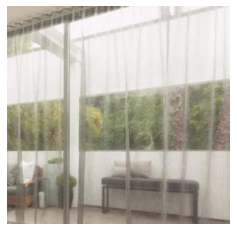

In [12]:
bg_factory = BackgroundFactory()

bg = bg_factory.get_random_background()
bg.display()
